In [5]:
using PyCall, PyPlot
@pyimport seaborn as sns

using Distributions: Chisq, Exponential, Normal, sample
import GynC: WeightedChain, reweight

In [6]:
jumptime(x) = 1 + 1 / (0.01 * x + 0.1)

pi0(x) = 1/200 # guessed prior
likelihood(x,z) = pdf(Normal(jumptime(x), 0.7), z)

function pi0_gridded(z, n)
  x = collect(linspace(0, 200., n))
  GynC.WeightedChain(x, map(pi0, x), [likelihood(x,z) for x in x, z in z])
end

function samplereality(n)
  x = rand(Chisq(8), n) * 5
  z = map(x->rand(Normal(jumptime(x), 0.7)), x)
  x,z
end;

evidence(z, xs, w) = sum([likelihood(xs[i],z) * w[i] for i in 1:length(xs)])
evidence_true(z, x_true) = sum([likelihood(x,z) / length(x_true) for x in x_true]);

In [16]:
srand(5)

x_true, z_true = samplereality(20);

@time pi_n = reweight(pi0_gridded(z_true, 1000), [0;2.^(0:15)]);

 19.785701 seconds (35.06 k allocations: 10.236 MB, 0.13% gc time)


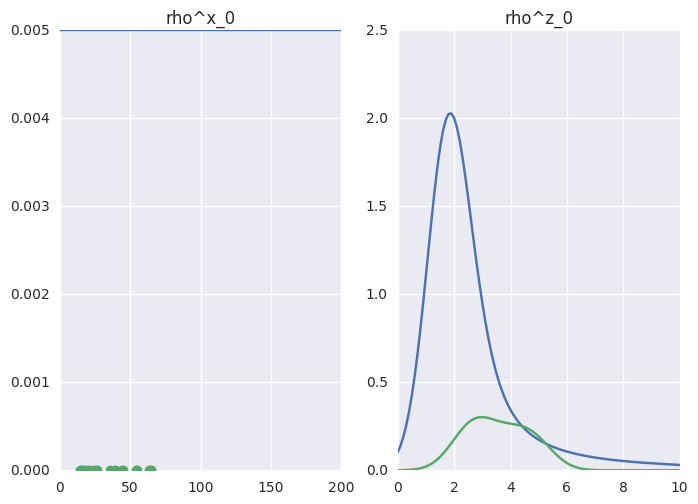

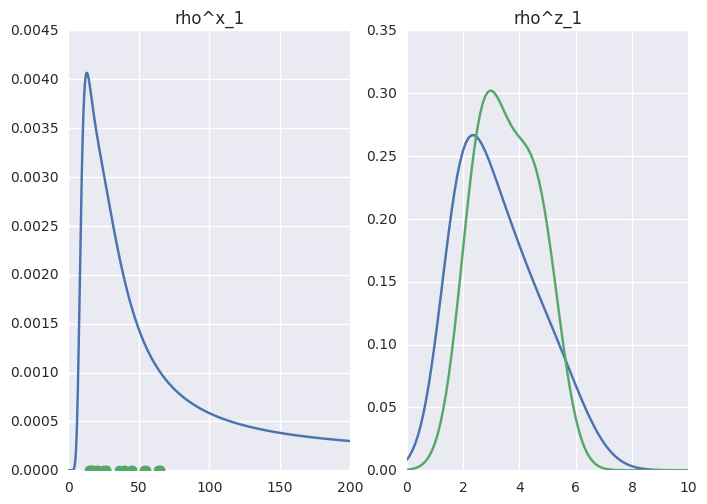

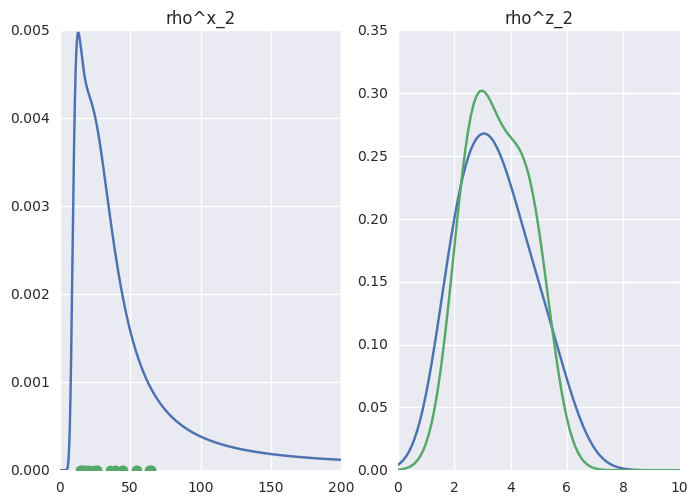

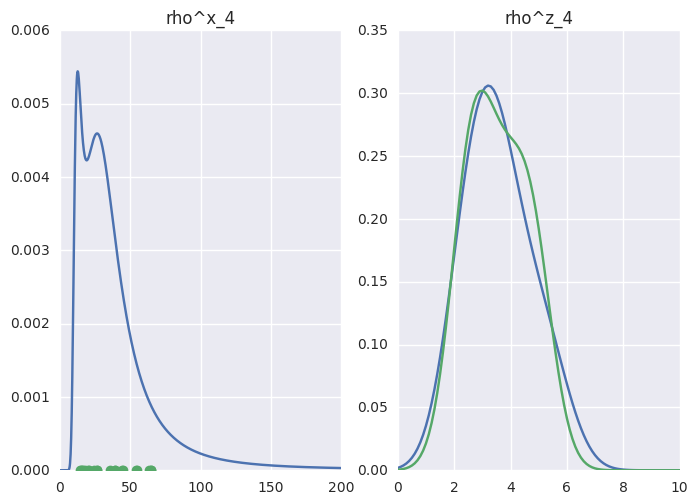

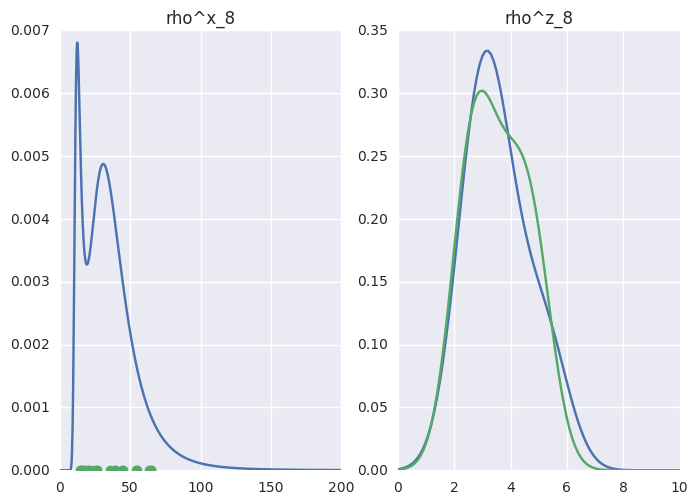

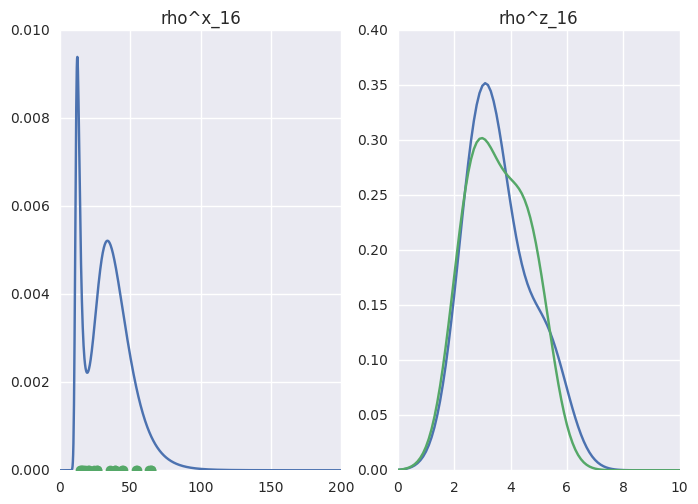

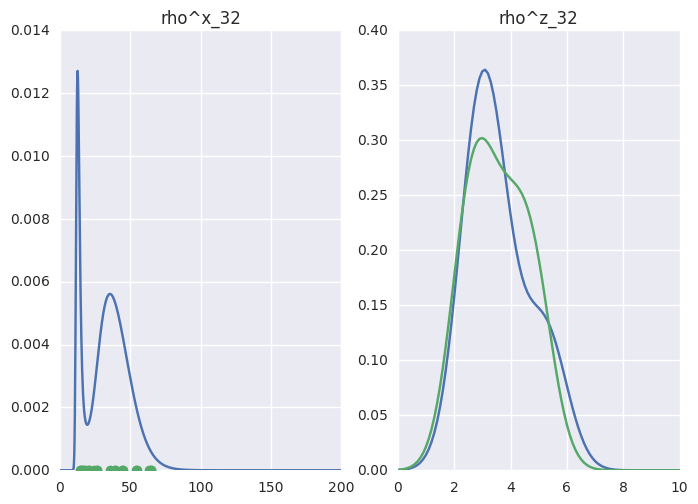

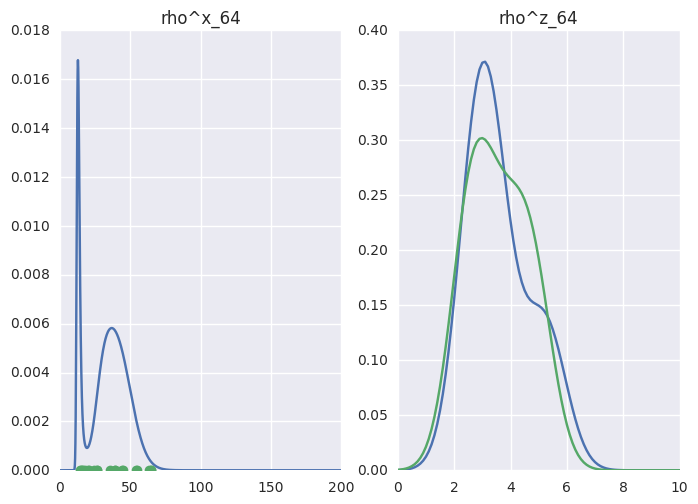

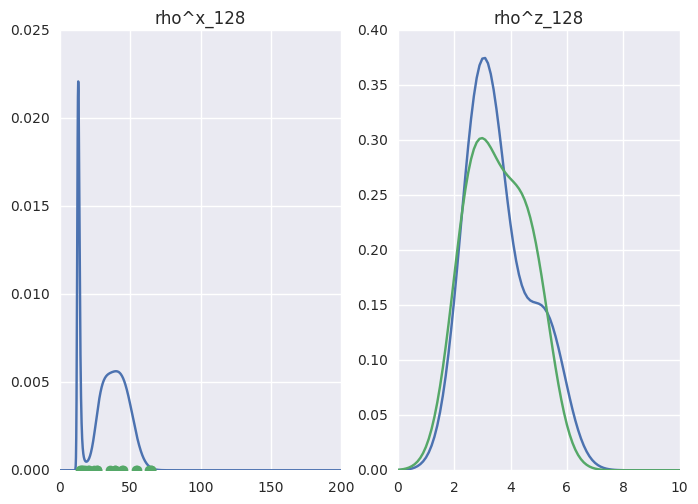

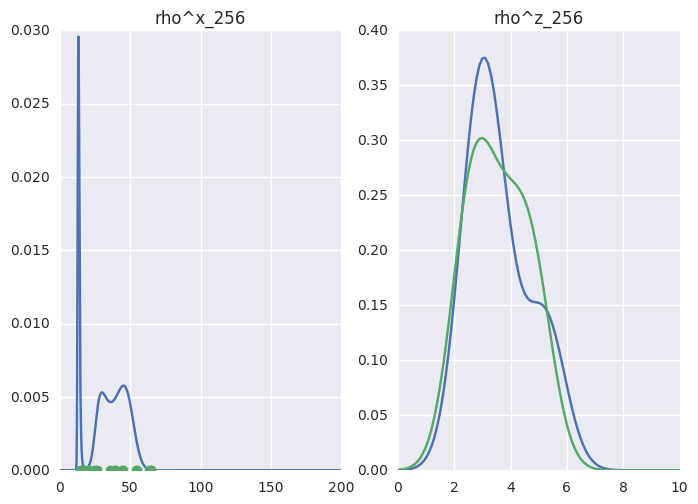

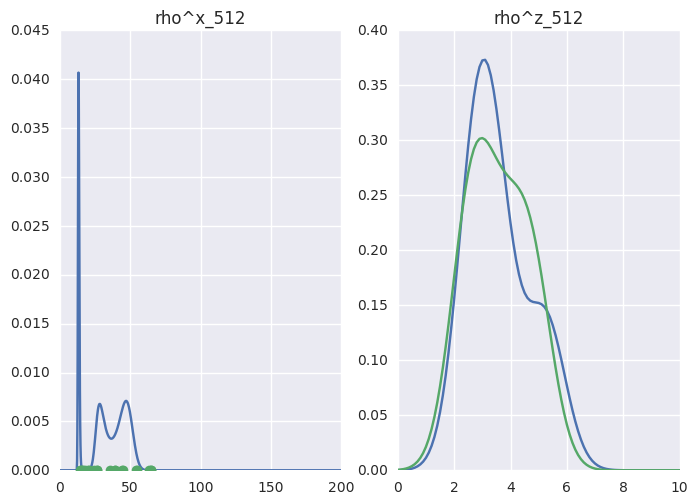

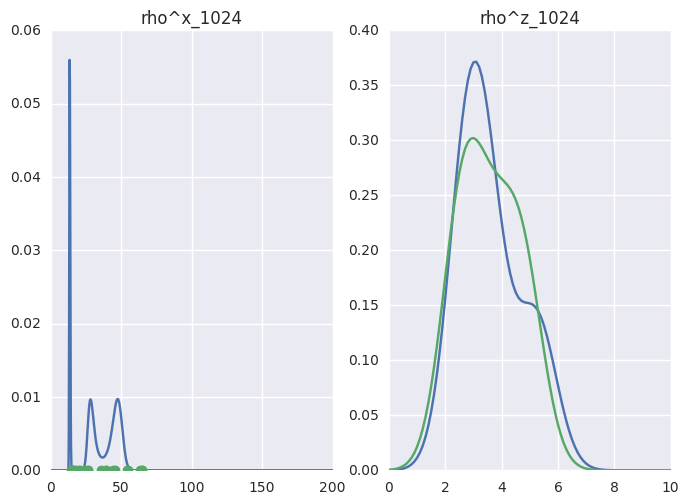

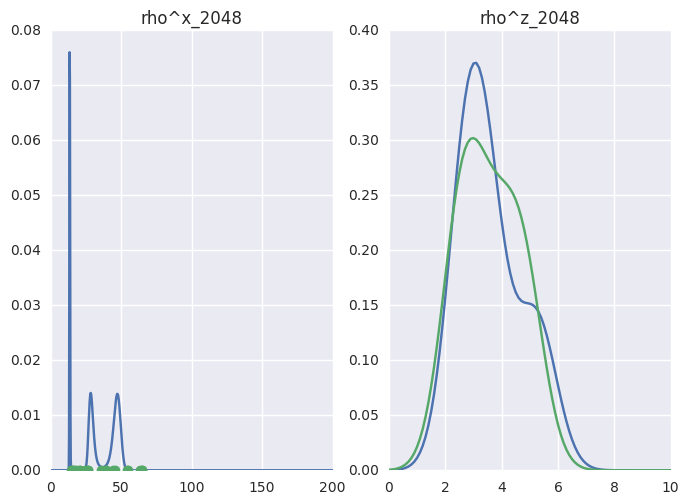

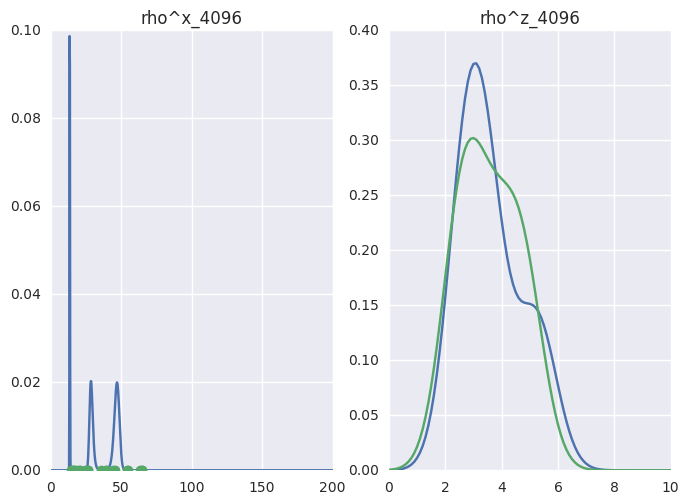

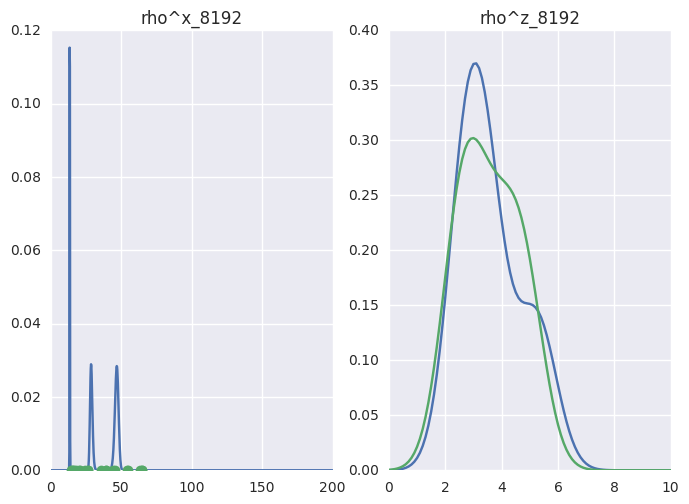

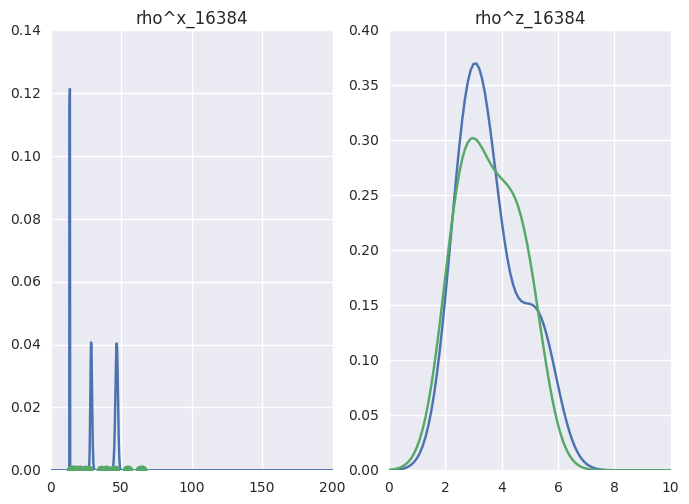

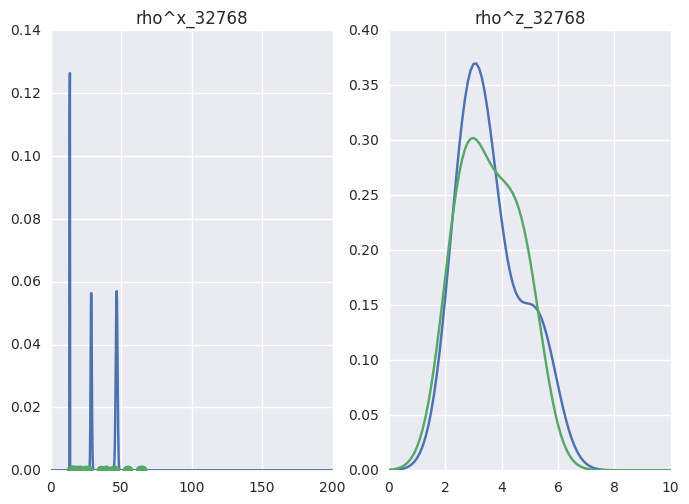

In [17]:
function plot_x(wc::WeightedChain)
    PyPlot.plot(wc.chain|>vec, wc.weights)
    PyPlot.plot(x_true, fill(0, length(x_true)), "o")
end

function plot_z(wc::WeightedChain, x_true)
    zgrid = collect(0:0.1:10)

    PyPlot.plot(zgrid, map(z->evidence(z, wc.chain, wc.weights), zgrid))
    PyPlot.plot(zgrid, map(z->evidence_true(z, x_true), zgrid))
end

for (n,pi) in sort(collect(pi_n), by=x->x[1])
    figure()
        
    subplot(121)
    hold(:on)
    plot_x(pi)
    title("rho^x_$n")  
    
    subplot(122)
    
    plot_z(pi, x_true)
    title("rho^z_$n") 
    hold(:off)
    display()
end